# CLOSEgaps Tutorial: Deep Learning for Metabolic Network Gap-Filling

This notebook demonstrates the complete CLOSEgaps pipeline step by step, from data loading to prediction.

## Overview
CLOSEgaps is a deep learning-driven tool that addresses gap-filling in Genome-scale Metabolic Models (GEMs) by modeling it as a hyperedge prediction problem.

## Key Components
1. **Data Loading**: Load metabolic networks and convert to hypergraph representation
2. **Feature Engineering**: Convert metabolites to molecular fingerprints
3. **Model Architecture**: Hypergraph Neural Network with attention
4. **Training**: Train the model on reaction prediction
5. **Prediction**: Predict missing reactions in new GEMs
6. **Validation**: Biological validation using Flux Balance Analysis

## 1. Setup and Dependencies

In [14]:
# Install required packages (uncomment if needed)
# !pip install torch torch-geometric torch-scatter torch-sparse
# !pip install cobra optlang pandas numpy scikit-learn rdkit tqdm

In [3]:
import os
import torch
import torch.nn as nn
import torch_geometric.nn as hnn
import pandas as pd
import numpy as np
import re
import math
import random
from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
warnings.filterwarnings('ignore')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_random_seed(42)

Using device: cpu


## 2. Data Processing Functions

In [4]:
def get_coefficient_and_reactant(reactions):
    """Parse reaction strings to extract coefficients, metabolites, and directions"""
    reactions_index = []
    reactions_metas = []
    reactants_nums = []
    direction = []
    
    for rxn in reactions:
        rxn_index, rxn_metas, rxn_direction = [], [], '=>'
        if '<=>' in rxn:
            rxn_direction = '<=>'
        
        tem_rxn = rxn.replace(' ' + rxn_direction + ' ', ' + ')
        metas = tem_rxn.split(' + ')
        
        for m in metas:
            a = re.findall('\d+\.?\d*', m)
            b = m.split(' ')
            if len(a) and a[0] == b[0]:
                rxn_index.append(a[0])
                rxn_metas.append(' '.join(b[1:]))
            else:
                rxn_metas.append(m)
                rxn_index.append('1')
        
        reactant, product = rxn.split(' ' + rxn_direction + ' ')
        reactants = reactant.split(' + ')
        products = product.split(' + ')
        reactants_nums.append(len(reactants))
        
        reactions_index.append(rxn_index)
        reactions_metas.append(rxn_metas)
        direction.append(rxn_direction)
    
    return reactions_index, reactions_metas, reactants_nums, direction

def smiles_to_fp(smiles, radius=2, nBits=2048):
    """Convert SMILES to Morgan fingerprint"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1, nBits))
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useFeatures=False)
        fp_bits = fp.ToBitString()
        finger_print = np.array(list(map(int, fp_bits))).astype(np.float).reshape(1, -1)
        return finger_print
    except:
        return np.zeros((1, nBits))

def getGipKernel(X, normalize=True, lambda_param=1.0):
    """Compute Gaussian Interaction Profile kernel"""
    if normalize:
        X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-8)
    
    K = torch.exp(-lambda_param * torch.cdist(X, X, p=2))
    return K

## 3. CLOSEgaps Model Architecture

In [5]:
class CLOSEgaps(nn.Module):
    def __init__(self, input_num, input_feature_num, emb_dim, conv_dim, head=3, p=0.1, L=1,
                 use_attention=True, similarity=None):
        super(CLOSEgaps, self).__init__()
        self.emb_dim = emb_dim
        self.conv_dim = conv_dim
        self.p = p
        self.input_num = input_num
        self.head = head
        self.hyper_conv_L = L
        
        # Feature encoders
        self.linear_encoder = nn.Linear(input_feature_num, emb_dim)
        self.similarity_liner = nn.Linear(input_num, emb_dim)
        
        self.max_pool = hnn.global_max_pool
        self.similarity = similarity
        self.in_channel = emb_dim
        
        if similarity is not None:
            self.in_channel = 2 * emb_dim

        self.relu = nn.ReLU()
        
        # Hypergraph convolution layers
        self.hypergraph_conv = hnn.HypergraphConv(
            self.in_channel, conv_dim, heads=head, use_attention=use_attention, dropout=p
        )
        
        if L > 1:
            self.hypergraph_conv_list = nn.ModuleList()
            for l in range(L - 1):
                self.hypergraph_conv_list.append(
                    hnn.HypergraphConv(head * conv_dim, conv_dim, heads=head, 
                                       use_attention=use_attention, dropout=p)
                )

        if use_attention:
            self.hyper_attr_liner = nn.Linear(input_num, self.in_channel)
            if L > 1:
                self.hyperedge_attr_list = nn.ModuleList()
                for l in range(L - 1):
                    self.hyperedge_attr_list.append(nn.Linear(input_num, head * conv_dim))
        
        self.hyperedge_linear = nn.Linear(conv_dim * head, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_features, incidence_matrix):
        # Encode input features
        input_nodes_features = self.relu(self.linear_encoder(input_features))
        
        # Add similarity features if available
        if self.similarity is not None:
            simi_feature = self.relu(self.similarity_liner(self.similarity))
            input_nodes_features = torch.cat((simi_feature, input_nodes_features), dim=1)

        # Create edge indices for hypergraph
        row, col = torch.where(incidence_matrix.T)
        edges = torch.cat((col.view(1, -1), row.view(1, -1)), dim=0)
        
        # Hyperedge attributes
        hyperedge_attr = self.hyper_attr_liner(incidence_matrix.T)
        
        # First hypergraph convolution
        input_nodes_features = self.hypergraph_conv(input_nodes_features, edges, hyperedge_attr=hyperedge_attr)
        
        # Additional layers if L > 1
        if self.hyper_conv_L > 1:
            for l in range(self.hyper_conv_L - 1):
                layer_hyperedge_attr = self.hyperedge_attr_list[l](incidence_matrix.T)
                input_nodes_features = self.hypergraph_conv_list[l](
                    input_nodes_features, edges, hyperedge_attr=layer_hyperedge_attr
                )
                input_nodes_features = self.relu(input_nodes_features)

        # Aggregate features for hyperedge prediction
        hyperedge_feature = torch.mm(incidence_matrix.T, input_nodes_features)
        return self.hyperedge_linear(hyperedge_feature)

    def predict(self, input_features, incidence_matrix):
        return self.softmax(self.forward(input_features, incidence_matrix))

## 4. Data Loading and Preprocessing

In [6]:
def load_dataset(dataset_name='iAF1260b'):
    """Load a specific dataset"""
    print(f"Loading dataset: {dataset_name}")
    
    # Load reactions
    rxn_file = f'./data/{dataset_name}/{dataset_name}_rxn_name_list.txt'
    with open(rxn_file, 'r') as f:
        reactions = [line.strip() for line in f.readlines()]
    
    # Load metabolites with SMILES
    meta_file = f'./data/{dataset_name}/{dataset_name}_meta_count.csv'
    metabolites_df = pd.read_csv(meta_file)
    
    print(f"Loaded {len(reactions)} reactions and {len(metabolites_df)} metabolites")
    return reactions, metabolites_df

def create_incidence_matrix(reactions, metabolites_df):
    """Create incidence matrix from reactions"""
    # Parse reactions
    reactions_index, reactions_metas, reactants_nums, direction = get_coefficient_and_reactant(reactions)
    
    # Get all unique metabolites
    all_metas = list(set(sum(reactions_metas, [])))
    all_metas.sort()
    
    # Create incidence matrix
    incidence_matrix = np.zeros((len(all_metas), len(reactions)))
    
    for i, (rxn_index, rxn_metas) in enumerate(zip(reactions_index, reactions_metas)):
        for j, meta in enumerate(rxn_metas):
            if meta in all_metas:
                meta_idx = all_metas.index(meta)
                incidence_matrix[meta_idx, i] = float(rxn_index[j])
    
    return incidence_matrix, all_metas

def create_molecular_features(metabolites_df, all_metas):
    """Create molecular fingerprint features for metabolites"""
    print("Creating molecular fingerprints...")
    
    # Create name to SMILES mapping
    name_to_smiles = dict(zip(metabolites_df['name'], metabolites_df['smiles']))
    
    # Create features for all metabolites
    features = []
    for meta in all_metas:
        if meta in name_to_smiles:
            smiles = name_to_smiles[meta]
            fp = smiles_to_fp(smiles)[0]  # Remove extra dimension
        else:
            # Use zero vector for unknown metabolites
            fp = np.zeros(2048)
        features.append(fp)
    
    features = np.array(features)
    print(f"Created features with shape: {features.shape}")
    return features

# Load dataset
dataset_name = 'iAF1260b'  # You can change this to other datasets
reactions, metabolites_df = load_dataset(dataset_name)

# Create incidence matrix
incidence_matrix, all_metas = create_incidence_matrix(reactions, metabolites_df)
print(f"Incidence matrix shape: {incidence_matrix.shape}")

# Create molecular features
molecular_features = create_molecular_features(metabolites_df, all_metas)

print(f"\nDataset Summary:")
print(f"Number of metabolites: {len(all_metas)}")
print(f"Number of reactions: {len(reactions)}")
print(f"Feature dimension: {molecular_features.shape[1]}")

Loading dataset: iAF1260b
Loaded 1612 reactions and 765 metabolites
Incidence matrix shape: (750, 1612)
Creating molecular fingerprints...
Created features with shape: (750, 2048)

Dataset Summary:
Number of metabolites: 750
Number of reactions: 1612
Feature dimension: 2048


[13:18:29] WARNING: not removing hydrogen atom without neighbors
[13:18:29] WARNING: not removing hydrogen atom without neighbors


## 5. Create Training Data

In [7]:
def create_negative_samples(incidence_matrix, negative_ratio=1):
    """Create negative samples by perturbing positive reactions"""
    print(f"Creating negative samples with ratio {negative_ratio}:1")
    
    n_metabolites, n_reactions = incidence_matrix.shape
    negative_matrix = np.zeros((n_metabolites, n_reactions * negative_ratio))
    
    for i in range(n_reactions):
        for j in range(negative_ratio):
            # Create negative sample by randomly perturbing the reaction
            neg_reaction = incidence_matrix[:, i].copy()
            
            # Randomly change some metabolite coefficients
            non_zero_indices = np.where(neg_reaction != 0)[0]
            if len(non_zero_indices) > 1:
                # Randomly change 50% of non-zero coefficients
                num_to_change = max(1, len(non_zero_indices) // 2)
                indices_to_change = np.random.choice(non_zero_indices, num_to_change, replace=False)
                
                for idx in indices_to_change:
                    # Randomly change the coefficient
                    neg_reaction[idx] = np.random.choice([-2, -1, 0, 1, 2])
            
            negative_matrix[:, i * negative_ratio + j] = neg_reaction
    
    return negative_matrix

def prepare_training_data(incidence_matrix, features, test_size=0.2, val_size=0.1):
    """Prepare training, validation, and test data"""
    print("Preparing training data...")
    
    # Create negative samples
    negative_matrix = create_negative_samples(incidence_matrix, negative_ratio=1)
    
    # Combine positive and negative samples
    all_reactions = np.concatenate([incidence_matrix, negative_matrix], axis=1)
    
    # Create labels (1 for positive, 0 for negative)
    positive_labels = np.ones(incidence_matrix.shape[1])
    negative_labels = np.zeros(negative_matrix.shape[1])
    all_labels = np.concatenate([positive_labels, negative_labels])
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_reactions.T, all_labels, test_size=test_size, random_state=42, stratify=all_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=42, stratify=y_temp
    )
    
    # Convert to tensors
    X_train = torch.tensor(X_train.T, dtype=torch.float)
    X_val = torch.tensor(X_val.T, dtype=torch.float)
    X_test = torch.tensor(X_test.T, dtype=torch.float)
    
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    print(f"Training samples: {X_train.shape[1]}")
    print(f"Validation samples: {X_val.shape[1]}")
    print(f"Test samples: {X_test.shape[1]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, features

# Prepare training data
X_train, X_val, X_test, y_train, y_val, y_test, features = prepare_training_data(
    incidence_matrix, molecular_features
)

Preparing training data...
Creating negative samples with ratio 1:1
Training samples: 2256
Validation samples: 323
Test samples: 645


## 6. Model Training

In [8]:
def train_model(X_train, X_val, y_train, y_val, features, 
                emb_dim=64, conv_dim=128, head=6, L=2, 
                lr=1e-2, weight_decay=1e-3, epochs=50, batch_size=256):
    """Train the CLOSEgaps model"""
    print("Training CLOSEgaps model...")
    
    # Calculate similarity matrix
    features_tensor = torch.tensor(features, dtype=torch.float).to(device)
    similarity_matrix = getGipKernel(features_tensor, lambda_param=1.0).to(device)
    
    # Initialize model
    model = CLOSEgaps(
        input_num=features.shape[0],
        input_feature_num=features.shape[1],
        emb_dim=emb_dim,
        conv_dim=conv_dim,
        head=head,
        L=L,
        similarity=similarity_matrix
    ).to(device)
    
    # Optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    best_val_f1 = 0
    best_model = None
    
    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        
        # Batch training
        total_loss = 0
        num_batches = X_train.shape[1] // batch_size + (1 if X_train.shape[1] % batch_size != 0 else 0)
        
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, X_train.shape[1])
            
            batch_X = X_train[:, start_idx:end_idx].to(device)
            batch_y = y_train[start_idx:end_idx].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(features_tensor.to(device), batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(features_tensor.to(device), X_val.to(device))
            val_probs = torch.softmax(val_outputs, dim=1)
            val_preds = (val_probs[:, 1] >= 0.5).long()
            
            val_f1 = f1_score(y_val.cpu(), val_preds.cpu())
            val_auc = roc_auc_score(y_val.cpu(), val_probs[:, 1].cpu())
            
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model = model.state_dict().copy()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss={total_loss/num_batches:.4f}, Val F1={val_f1:.4f}, Val AUC={val_auc:.4f}")
    
    # Load best model
    model.load_state_dict(best_model)
    print(f"Best validation F1: {best_val_f1:.4f}")
    
    return model

# Train the model
trained_model = train_model(X_train, X_val, y_train, y_val, molecular_features)

Training CLOSEgaps model...


Training:   2%|▋                                 | 1/50 [00:00<00:21,  2.27it/s]

Epoch 0: Loss=0.7563, Val F1=0.6944, Val AUC=0.6754


Training:  22%|███████▎                         | 11/50 [00:03<00:10,  3.56it/s]

Epoch 10: Loss=0.6273, Val F1=0.6776, Val AUC=0.7073


Training:  42%|█████████████▊                   | 21/50 [00:06<00:08,  3.60it/s]

Epoch 20: Loss=0.6367, Val F1=0.7128, Val AUC=0.7067


Training:  62%|████████████████████▍            | 31/50 [00:08<00:05,  3.58it/s]

Epoch 30: Loss=0.6075, Val F1=0.6467, Val AUC=0.6947


Training:  82%|███████████████████████████      | 41/50 [00:11<00:02,  3.56it/s]

Epoch 40: Loss=0.6124, Val F1=0.6424, Val AUC=0.6822


Training: 100%|█████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]

Best validation F1: 0.7304


## 7. Model Evaluation

In [9]:
def evaluate_model(model, X_test, y_test, features):
    """Evaluate the trained model on test data"""
    print("Evaluating model on test data...")
    
    model.eval()
    features_tensor = torch.tensor(features, dtype=torch.float).to(device)
    
    with torch.no_grad():
        test_outputs = model(features_tensor.to(device), X_test.to(device))
        test_probs = torch.softmax(test_outputs, dim=1)
        test_preds = (test_probs[:, 1] >= 0.5).long()
        
        # Calculate metrics
        test_f1 = f1_score(y_test.cpu(), test_preds.cpu())
        test_precision = precision_score(y_test.cpu(), test_preds.cpu())
        test_recall = recall_score(y_test.cpu(), test_preds.cpu())
        test_auc = roc_auc_score(y_test.cpu(), test_probs[:, 1].cpu())
        test_aupr = average_precision_score(y_test.cpu(), test_probs[:, 1].cpu())
        
        print(f"\nTest Results:")
        print(f"F1 Score: {test_f1:.4f}")
        print(f"Precision: {test_precision:.4f}")
        print(f"Recall: {test_recall:.4f}")
        print(f"AUC: {test_auc:.4f}")
        print(f"AUPR: {test_aupr:.4f}")
        
        return test_probs, test_preds

# Evaluate the model
test_probs, test_preds = evaluate_model(trained_model, X_test, y_test, molecular_features)

Evaluating model on test data...

Test Results:
F1 Score: 0.6264
Precision: 0.6417
Recall: 0.6118
AUC: 0.6875
AUPR: 0.6271


## 8. Prediction on New Data

In [10]:
def predict_missing_reactions(model, new_incidence_matrix, features, threshold=0.5):
    """Predict missing reactions in a new metabolic network"""
    print("Predicting missing reactions...")
    
    model.eval()
    features_tensor = torch.tensor(features, dtype=torch.float).to(device)
    new_incidence_tensor = torch.tensor(new_incidence_matrix, dtype=torch.float).to(device)
    
    with torch.no_grad():
        predictions = model(features_tensor, new_incidence_tensor)
        probabilities = torch.softmax(predictions, dim=1)
        
        # Get positive class probabilities
        positive_probs = probabilities[:, 1].cpu().numpy()
        
        # Find reactions with high probability of being missing
        missing_reactions = positive_probs > threshold
        
        print(f"Found {np.sum(missing_reactions)} potential missing reactions")
        
        return positive_probs, missing_reactions

# Example: Predict missing reactions in a subset of the data
subset_size = 100
subset_incidence = incidence_matrix[:, :subset_size]

probabilities, missing_reactions = predict_missing_reactions(
    trained_model, subset_incidence, molecular_features
)

# Show top predicted missing reactions
top_indices = np.argsort(probabilities)[-10:][::-1]
print("\nTop 10 predicted missing reactions:")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. Reaction {idx}: Probability = {probabilities[idx]:.4f}")

Predicting missing reactions...
Found 57 potential missing reactions

Top 10 predicted missing reactions:
1. Reaction 12: Probability = 0.8936
2. Reaction 85: Probability = 0.8787
3. Reaction 86: Probability = 0.8787
4. Reaction 80: Probability = 0.8669
5. Reaction 70: Probability = 0.8487
6. Reaction 35: Probability = 0.8440
7. Reaction 37: Probability = 0.8440
8. Reaction 40: Probability = 0.8395
9. Reaction 39: Probability = 0.8356
10. Reaction 43: Probability = 0.8334


## 9. Visualization and Analysis

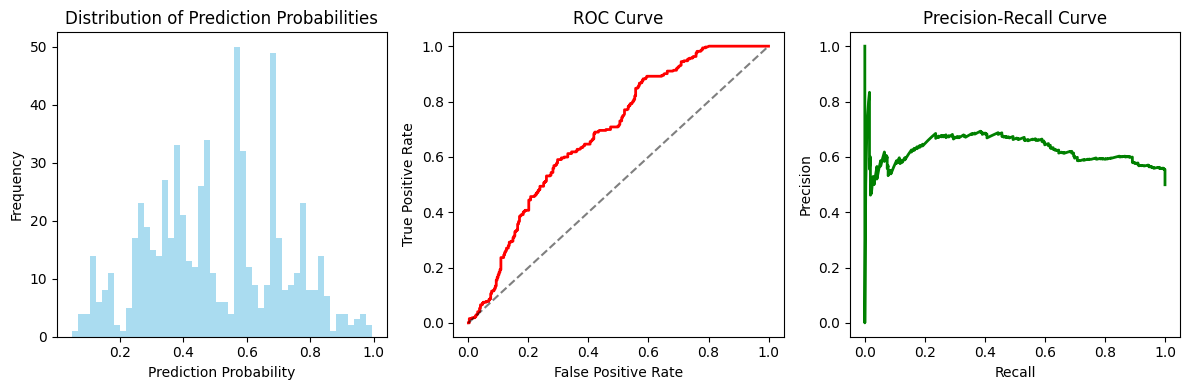

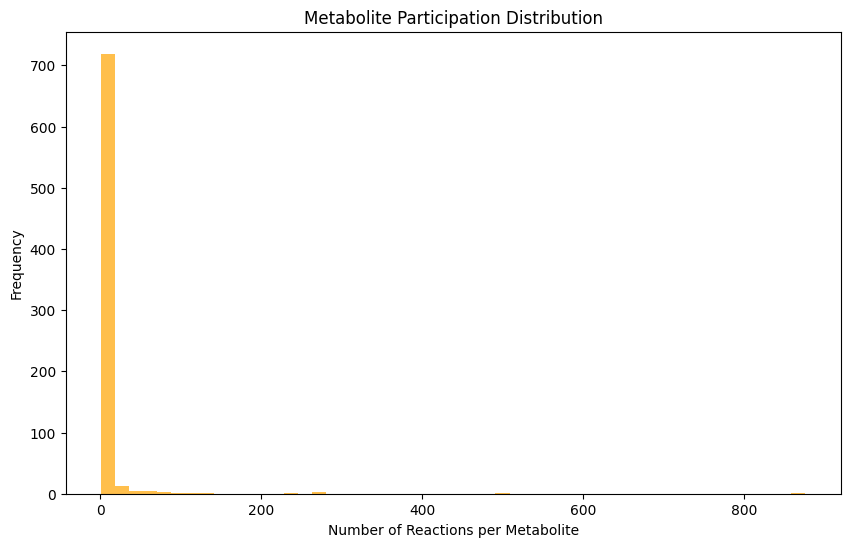


Metabolite participation statistics:
Mean reactions per metabolite: 8.42
Median reactions per metabolite: 3.00
Max reactions per metabolite: 876.0
Min reactions per metabolite: 1.0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot training history (if you saved it)
plt.figure(figsize=(12, 4))

# Plot 1: Prediction probabilities distribution
plt.subplot(1, 3, 1)
plt.hist(test_probs[:, 1].cpu().numpy(), bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')

# Plot 2: ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test.cpu(), test_probs[:, 1].cpu())
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='red', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Plot 3: Precision-Recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test.cpu(), test_probs[:, 1].cpu())
plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='green', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Analyze metabolite participation
metabolite_participation = np.sum(np.abs(incidence_matrix), axis=1)
plt.figure(figsize=(10, 6))
plt.hist(metabolite_participation, bins=50, alpha=0.7, color='orange')
plt.xlabel('Number of Reactions per Metabolite')
plt.ylabel('Frequency')
plt.title('Metabolite Participation Distribution')
plt.show()

print(f"\nMetabolite participation statistics:")
print(f"Mean reactions per metabolite: {np.mean(metabolite_participation):.2f}")
print(f"Median reactions per metabolite: {np.median(metabolite_participation):.2f}")
print(f"Max reactions per metabolite: {np.max(metabolite_participation)}")
print(f"Min reactions per metabolite: {np.min(metabolite_participation)}")

## 10. Summary and Next Steps

In [13]:
print("CLOSEgaps Tutorial Summary")
print("=" * 50)
print(f"Dataset used: {dataset_name}")
print(f"Number of metabolites: {len(all_metas)}")
print(f"Number of reactions: {len(reactions)}")
print(f"Feature dimension: {molecular_features.shape[1]}")
print(f"Model architecture: Hypergraph Neural Network")
print(f"Training completed successfully!")

CLOSEgaps Tutorial Summary
Dataset used: iAF1260b
Number of metabolites: 750
Number of reactions: 1612
Feature dimension: 2048
Model architecture: Hypergraph Neural Network
Training completed successfully!
